In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy
import numba

plt.rc('font', **{"size": 16})

In [200]:
def lastNonZero(series: np.ndarray):
    return len(series) - np.where(series[::-1] > 0)[0][0]

def plotDistribution(
    particlesInCompartment: np.ndarray, 
    numberOfParticles: int, 
    analyticalParticleDistribution: np.ndarray = None,
    analyticalCompartmentDistribution: np.ndarray = None
    ):
    
    numberOfCompartments = particlesInCompartment.shape[1]
    colors = plt.cm.cividis(np.linspace(1, 0, numberOfCompartments))    
    
    # Create a figure with a custom gridspec
    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1])  # Two rows, two columns, bottom row is taller

    # Create the subplots
    ax0 = fig.add_subplot(gs[0, 0])  # Top-left
    ax1 = fig.add_subplot(gs[0, 1])  # Top-right
    ax2 = fig.add_subplot(gs[1, :])  # Bottom, spanning both columns

        
    totalDistribution = np.zeros(numberOfParticles)
    for c in range(numberOfCompartments):
        distribution, _ = np.histogram(particlesInCompartment[:, c], bins=numberOfParticles, range=(-0.5, numberOfParticles+0.5), density=True)
        ax0.plot(distribution, label=f"$E_{{{c}}}$", c=colors[c], lw=1)
        totalDistribution += distribution
        
    if analyticalParticleDistribution is not None:
        ax0.plot(analyticalParticleDistribution, label="Analytical", c='black')
        
    ax0.set_xlabel("Number of particles")
    ax0.set_ylabel("Density")
    ax0.set_xlim(0, lastNonZero(totalDistribution))
    ax0.legend(fontsize=12)
    
    ax1.boxplot(particlesInCompartment, patch_artist=True, boxprops=dict(facecolor="skyblue"), tick_labels=np.arange(numberOfCompartments))    
    ax1.set_xlabel("Compartment")
    ax1.set_ylabel("Number of particles")
    if analyticalCompartmentDistribution is not None:
        ax1.plot(np.arange(numberOfCompartments) + 1, analyticalCompartmentDistribution, label="Analytical", c="black")
    ax1.legend()

    ax2.axis("off")
    ax2.text(0.3, 0.0, "Distribution in last cycle", fontsize=24)
    for i, val in enumerate(particlesInCompartment[-1]):
        ax2.add_patch(plt.Rectangle((i/numberOfCompartments, 0.25), 1 / (numberOfCompartments + 1), 0.5, edgecolor='black', facecolor='skyblue'))
        ax2.text(((i+0.45)/numberOfCompartments), 0.5, str(val), fontsize=24, ha='center', va='center', color='black')
        
    fig.tight_layout()
    
def sampler(numberOfCycles: int, numberOfParticles: int, numberOfCompartments: int, probabilities: np.ndarray):
    particlesInCompartment = np.zeros((numberOfCycles, numberOfCompartments), dtype=np.int32)
    for cycle in range(cycle):
        for i in range(numberOfParticles):
            compartment = np.random.choice(numberOfCompartments, p=probabilities)
            particlesInCompartment[cycle, compartment] += 1
    return particlesInCompartment

### Non-interacting

In [166]:
def analyticalParticleDistribution(numberOfParticles: int, numberOfCompartments: int):
    idx = np.arange(numberOfParticles)
    
    # get binomial coefficients npr(N, j) in array
    binomCoeffs = scipy.special.binom(numberOfParticles, idx)
    
    # precompute p
    p = 1 / numberOfCompartments
    
    # return binomial pmf
    return binomCoeffs * p**idx * (1-p)**(numberOfParticles - idx)

In [ ]:
numberOfParticles = 500
numberOfCompartments = 12
numberOfCycles = 1000

probabilities = np.ones(numberOfCompartments) / numberOfCompartments

particlesInCompartment = np.zeros((numberOfCycles, numberOfCompartments), dtype=np.int32)

In [168]:
for cycle in range(numberOfCycles):
    for i in range(numberOfParticles):
        compartment = np.random.randint(0, numberOfCompartments)
        particlesInCompartment[cycle, compartment] += 1

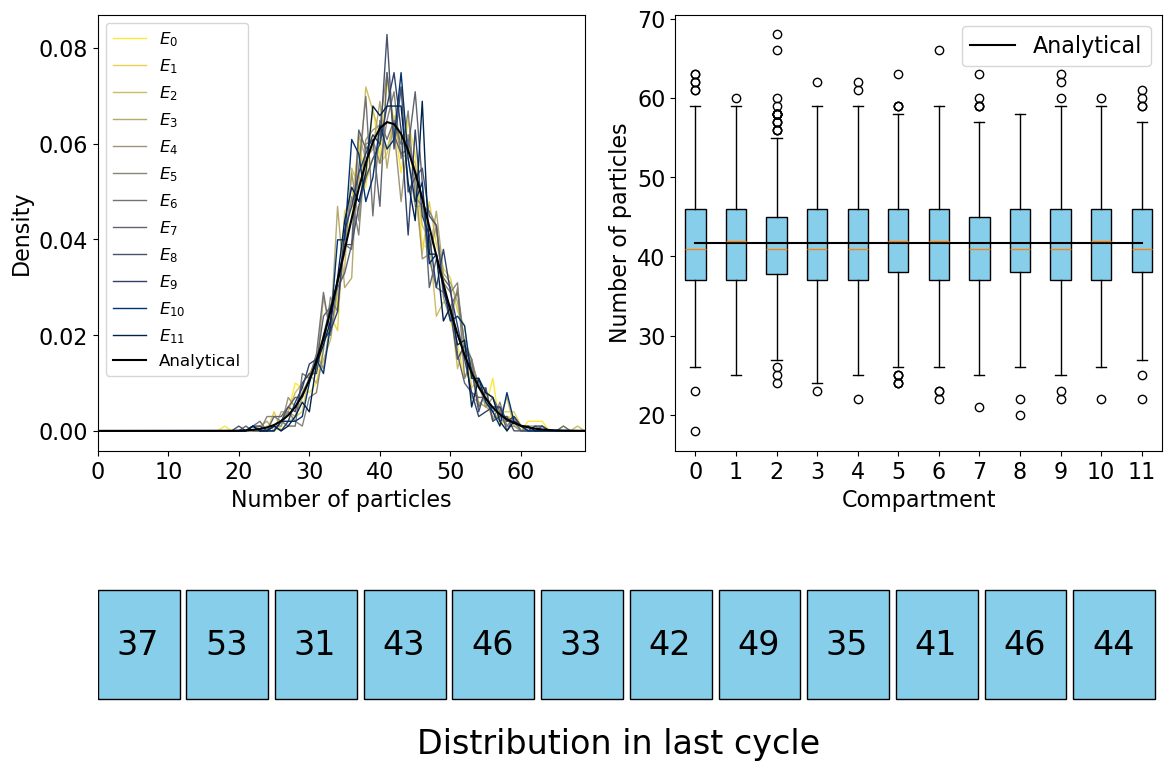

In [169]:
plotDistribution(
    particlesInCompartment,
    numberOfParticles,
    analyticalParticleDistribution(numberOfParticles, numberOfCompartments),
    np.ones(numberOfCompartments) * (numberOfParticles / numberOfCompartments)
)

### Non-interacting $E_i = i$

In [186]:
numberOfParticles = 500
numberOfCompartments = 8
numberOfCycles = 1000
beta = 0.5

particlesInCompartment = np.zeros((numberOfCycles, numberOfCompartments), dtype=np.int32)

In [187]:
energies = np.arange(numberOfCompartments)
partitionFunction = np.sum(np.exp(-beta * energies))
probabilities = np.exp(-beta * energies) / partitionFunction

In [190]:
for cycle in range(numberOfCycles):
    for i in range(numberOfParticles):
        compartment = np.random.choice(numberOfCompartments, p=probabilities)
        particlesInCompartment[cycle, compartment] += 1

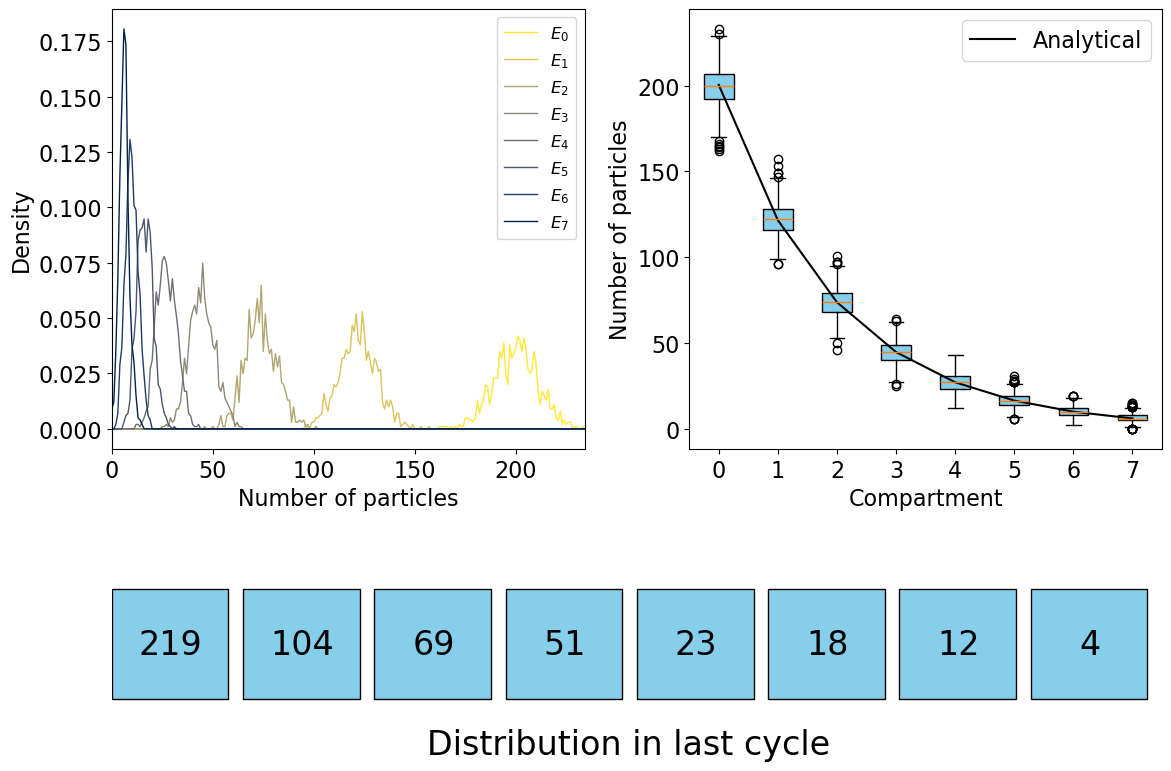

In [189]:
plotDistribution(
    particlesInCompartment,
    numberOfParticles,
    None,
    probabilities * numberOfParticles
    )

### Non-interacting $E_i = \frac{i(i+1)}{2}$

In [195]:
numberOfParticles = 500
numberOfCompartments = 12
numberOfCycles = 10000
beta = 0.1

particlesInCompartment = np.zeros((numberOfCycles, numberOfCompartments), dtype=np.int32)

In [196]:
indices = np.arange(numberOfCompartments)
energies = indices * (indices + 1)
partitionFunction = np.sum((indices + 1) * np.exp(-beta * energies))
probabilities = (indices + 1) * np.exp(-beta * energies) / partitionFunction

In [197]:
for cycle in range(numberOfCycles):
    for i in range(numberOfParticles):
        compartment = np.random.choice(numberOfCompartments, p=probabilities)
        particlesInCompartment[cycle, compartment] += 1

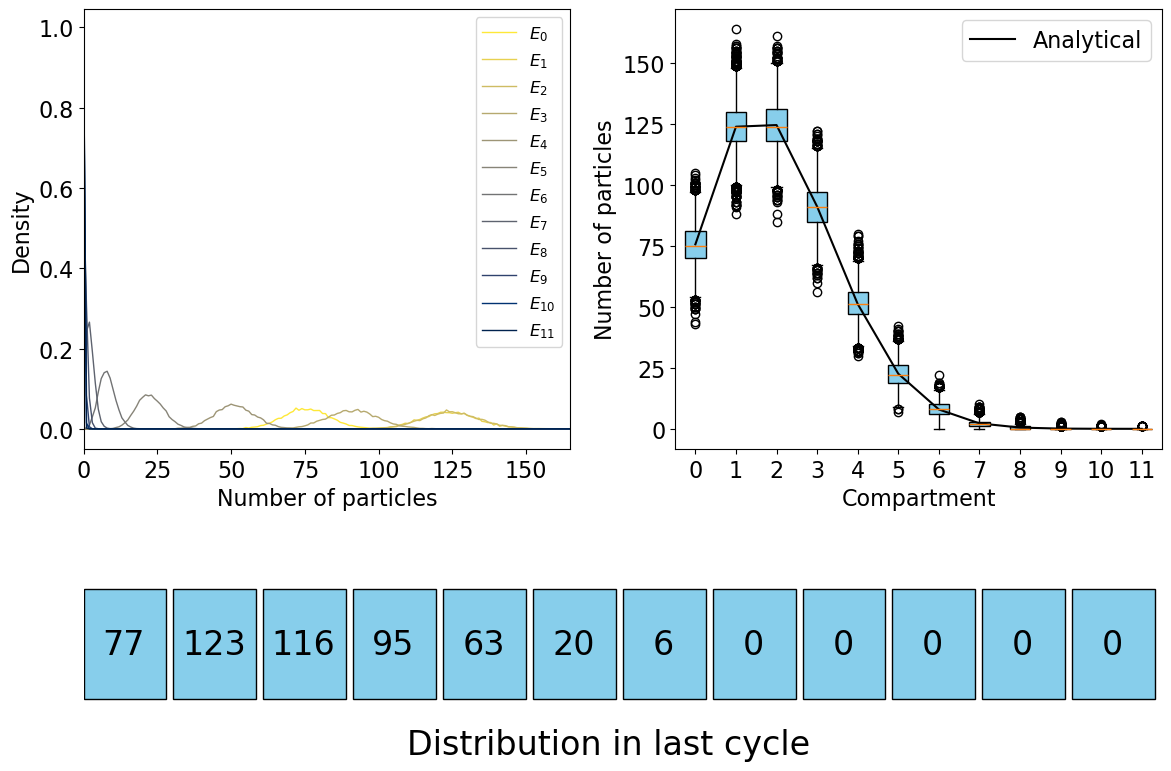

In [199]:
plotDistribution(
    particlesInCompartment,
    numberOfParticles,
    None,
    probabilities * numberOfParticles
)

### Interacting oscillators

In [ ]:
@numba.jit
def NVE(numberOfOscillators, numberOfCycles, totalEnergy):
    initSteps = int(np.floor(0.5 * numberOfCycles))
    
    oscillator = np.zeros((numberOfCycles, numberOfOscillators), dtype=np.int32)
    distribution = np.zeros(totalEnergy+1, dtype=np.float32)

    # Distribute the total energy among oscillators
    for energy in range(totalEnergy):
        oscillator[0, energy % numberOfOscillators] += 1

    print(f"Initial energy {oscillator.sum()}")

    for cycle in range(1, numberOfCycles):
        oscillator[cycle] = oscillator[cycle - 1]
        for _ in range(numberOfOscillators):
            # Select two particles
            oscA, oscB = np.random.choice(numberOfOscillators, 2, replace=False)
            
            # Choose a random exchange direction
            flip = -1 if np.random.rand() < 0.5 else 1
            
            # If energy will not go negative, accept exchange
            if min(oscillator[cycle, oscA] + flip, oscillator[cycle, oscB] - flip) >= 0.0:
                oscillator[cycle, oscA] += flip
                oscillator[cycle, oscB] -= flip

        # Update the distribution after half the cycles
        if cycle > initSteps:
            distribution[oscillator[0]] += 1
    
    return oscillator

@numba.jit
def NVT(numberOfOscillators, numberOfCycles, beta):
    initSteps = int(np.floor(0.5 * numberOfCycles))
    oscillator = np.zeros(numberOfOscillators, dtype=np.int32)
    distribution = np.zeros(1000000, dtype=np.int32)
    
    print(f"Initial energy {oscillator.sum()}")
    for cycle in range(numberOfCycles):
        for _ in range(numberOfOscillators):
            # Select a particle
            oscA = np.random.choice(numberOfOscillators, 1)
            
            # Choose a random exchange direction
            flip = -1 if np.random.rand() < 0.5 else 1
            
            # accept according to Metropolis criterium
            if oscillator[oscA] + flip >= 0 and np.random.rand() < np.exp(-beta * flip):
                oscillator[oscA] += flip  
            
    
        # Update the distribution after half the cycles
        if cycle > initSteps:
            distribution[oscillator[0]] += 1
            
    # Trim trailing zeros
    k = find_last_nonzero_index(distribution)
    distribution = distribution[:k]
            
    print(f"Final energy {oscillator.sum()}")
    return distribution / distribution.sum()